In [1]:
import pyms
import numpy as np
import torch
#TODO: LOWENA, this first cell is just so you can see how this package works, play around with the defocus a bit
# Get crystal
from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

crystal = pyms.structure.fromfile(
    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
# structure
crystal = crystal.resize([0.1, 0.76], axis=0)
from copy import deepcopy

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)


# Quick plot of crystal
# crystal.quickplot(atomscale=1e-5)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])

# Set up  series of defocii
df = torch.tensor([200.0])


output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    df=df,
    tiling=tiling,
    nfph=1,
    showProgress='notebook', 
    apply_ctf = False,
)

import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(output)

Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

/scratch-ssd/tiarty/py_multislice_differentiable_tem/pyms/Premixed_routines.py:1502: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

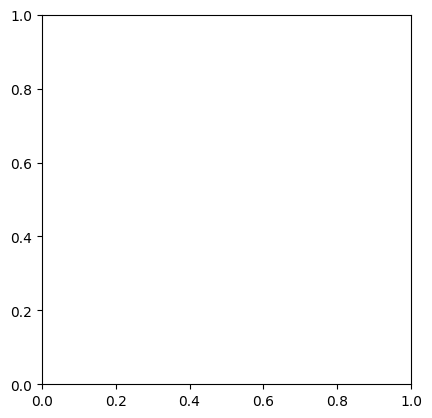

In [29]:
plt.imshow(output)

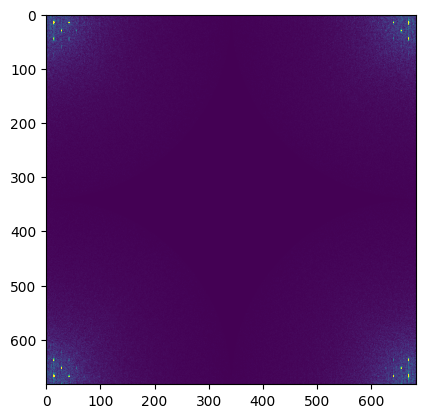

In [2]:
plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)

In [9]:
defocus = torch.tensor([100.], requires_grad = True)
bw_limit_size = size_of_bandwidth_limited_array(gridshape)
rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)
aberrations = []
optimizer = torch.optim.Adam([defocus], lr = 1e-1)
criterion = torch.nn.MSELoss()
n_iters = 2000
ref_data = np.load('/scratch-ssd/tiarty/data/df_200_test_data.npy')
ref_data = torch.tensor(ref_data).to('cuda')
loss_curve = []
defocii_curve = []
for iter in range(n_iters):
    ctf = (
            torch.stack(
                [
                    make_contrast_transfer_function(
                        bw_limit_size, rsize, eV, app, df=defocus, aberrations=aberrations
                    )
                ]
            )
        .type(torch.complex128)
        .to('cuda')
    )

    sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))
    
    optimizer.zero_grad()
    
    loss = criterion(sim_image, ref_data)*1000000000

    loss.backward()

    print(defocus.item())

    optimizer.step()

    loss_curve.append(loss.item())
    defocii_curve.append(defocus.item())
    #print(defocus)


300.0
299.0038757324219
298.0074157714844
297.0103454589844
296.0123291015625
295.012939453125
294.0116882324219
293.008056640625
292.0014343261719
290.9912109375
289.97674560546875
288.9573059082031
287.93218994140625
286.9006652832031
285.86199951171875
284.8154602050781
283.76031494140625
282.69586181640625
281.6214294433594
280.536376953125
279.44012451171875
278.33209228515625
277.2117919921875
276.07879638671875
274.93267822265625
273.7731018066406
272.59979248046875
271.4125061035156
270.21112060546875
268.9955139160156
267.765625
266.521484375
265.26312255859375
263.99066162109375
262.70428466796875
261.4041748046875
260.0906066894531
258.763916015625
257.4244384765625
256.07257080078125
254.70875549316406
253.33351135253906
251.9473876953125
250.55096435546875
249.1448974609375
247.72988891601562
246.3066864013672
244.87611389160156
243.43902587890625
241.99636840820312
240.54913330078125
239.098388671875
237.645263671875
236.19097900390625
234.73683166503906
233.2841796875
23

KeyboardInterrupt: 

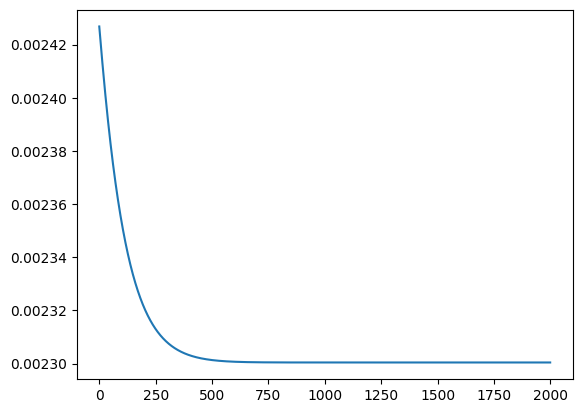

In [3]:
plt.plot(loss_curve)

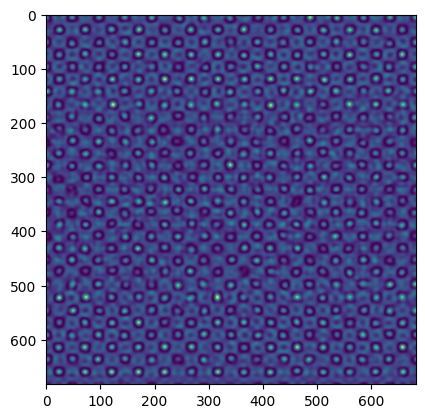

In [4]:
plt.imshow(sim_image[0].detach().cpu().numpy())

In [24]:
np.save('/scratch-ssd/tiarty/data/df_200_test_data.npy', output)

In [ ]:
test = chi(q = 1.3, qphi = 0.2, lam = 2e5, df = 0.1, aberrations = [])

In [ ]:
test

106185.83169133501

In [ ]:
#Now try with df a torch.tensor instead, the code actually works straight away haha
df_torch = torch.tensor([0.1], requires_grad = True)
test = chi(q = 1.3, qphi = 0.2, lam = 2e5, df = df_torch, aberrations = [])

In [ ]:
#create some scalar number we can backprop through
test = torch.sum(test**2)
#backprop
test.backward()
#check gradient of df_torch, we have a number so it's working!
print(df_torch.grad)

tensor([2.2551e+11])
